# Machine Learning Project

In [ ]:
# Daniel Moskalchuk 293172
# Julia Tankiewicz 293719
# Nikita Bondarchuk 294478

The assignments below should be solved and documented as a project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises.
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to.

Please hand in assignment 1-6 in a _**single**_ Jupyter notebook where you retain the questions outlined below. You are welcome to adapt code from the web (e.g. Kaggle kernels), but you **_must_** reference the original source in your notebook. In addition to _clean, well-documented code_ (i.e. functions with <a href="https://www.geeksforgeeks.org/python-docstrings/">docstrings</a>, etc), your notebook will be judged according to how well each step is explained (using Markdown). 

In general, direct questions regarding assignments 1, 4, 5 and 6 to Frederik, and questions regarding assignments 2, 3, and 7 to Richard. 

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

**Groups:** Create your own groups. May be across teams. 2-4 students per group. No one-person groups.


**Submission deadline:** Thursday, December 15 before 13.00 CET (Notebooks + presentation recording)

**Expected workload:** Each student is expected to spend around around 50 hours on the project.

### Deliverables
The teams have to submit three deliverables before the submission deadline: 1) a notebook of assignments 1-6, 2) a notebook of assignment 7, and 3) presentation video uploaded to some online platform e.g. YouTube, Vimeo, etc.

#### Notebook
The notebook contains all the code to explore the dataset, train the final model and documents each step clearly. If code is copied from another codebase such as Github or Stack Overflow it **_must_** be properly referenced.


#### Presentation
The presentation video should be 15 min long and should highlight the problem you are solving, interesting things you found in the data and the step involved in building up your model. At the exam we will discuss the presentation and ask questions about your project and submissions. A link to the video must be placed in the notebook for assignment 7.

### Randomness
For ALL random states, choose state = 69 so we can replicate your work.


In [183]:
# Import all necessary modules here:
#pip install opencv-python
#pip install keras

## Geopandas ##########
#pip install wheel
#pip install pipwin

#pipwin install shapely
#pipwin install gdal
#pipwin install fiona
#pipwin install pyproj
#pipwin install six
#pipwin install rtree
#pipwin install geopandas
#########################


#pip install --no-cache-dir tensorflow

from pathlib import Path
import numpy as np
import scipy.io
import ast
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import mglearn
import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
#from keras.preprocessing import image
#from tensorflow.keras.utils import load_img, img_to_array


## 1. The IceCat Dataset

__You should be able to do this exercise after Lecture 3.__

The IceCat Dataset, kindly provided to us by Stibo Systems, contains a large amount of data on different office products. As an example of "real-world" data, these data are imperfect and incomplete. As such, this exercise is not so much an exercise in creating a good machine learning model, but places a larger emphasis on "cleaning the data".

We are going to work with a subset of the IceCat Dataset. In particular, you will be provided with a zip file of 5,854 images of office products, each with the name "product ID".jpg. You will also be provided with a list of colors, `colors.txt`, which, when imported using the code below, is a list of tuples of the form `[("product ID", "color"), ...]`. (The code below assumes that `colors.txt` is in the same folder as the jupyter notebook. Feel free to change the code if you prefer a different organization of your files).

Your task is to clean up the data and construct a simple machine learning model (_e.g._, _k_-nearest neighbor) that can identify the color of a product. You have free hands - there is hardly any one "correct answer" - but you need to argue for your choices. Among other things, you probably need to think about the following as you work with the data:

* All of the images have different sizes.

* Some of the images are RGB images (3 layers), others are CMYK (4 layers), some might even be black-and-white (1 layer).

* Some colors are only represented by very few products.

* Some colors are very similar, such as "Purple" and "Violet".

* A product may have a particular color, but a packaging of a different color. Similarly, the color of, say, a computer monitor may be black, while the image of it could show a monitor that is turned on with a green screensaver.

* Many products are attributed to several colors, such as "Black, Blue" or even "Blue, Green, Orange, Violet, Yellow". Yet others are described as "Multicolor" or "Assorted colors".

Again, you have free hands in how you are going to solve these (and other) challenges, but you must argue for and reflect on your choices as you progress.


In [136]:
# for some binning
color_mappings = {
  # source color => arr of colors associated with the source color
    'Grey' : ['Silver', 'Metallic', 'Aluminium', 'Stainless steel', 'Platinum', 'Graphite', 'Chrome', 'Anthracite','Light Grey','Charcoal','Titanium','Light grey'],
    'Purple' : ['Violet', 'Lavender', 'Fuchsia','Magenta'],
    'Transparent' : ['Translucent'],
    'Cream' : ['Beige', 'Sand', 'Tan','Cappuccino','Ivory'],
    'Brown' : ['Oak colour', 'Wood','Bronze'],
    'Cyan' : ['Turquoise', 'Aqua colour'],
    'White' : ['Pearl' ],
    'Pink' : ['Rose'],
    'Red' : ['Cherry', 'Bordeaux'],
    'Green' : ['Pine', 'Lime','Olive'],
    'Yellow' : ['Gold'],
    'Blue' : ['Navy'],
    'Multicolour' : ['Multi','Assorted colours']
}

def colors_binning(initial_color):
    for source_color in color_mappings:
        if initial_color in color_mappings[source_color]: return source_color;
        
    return initial_color;
        
with open("datasets/1/colors.txt","r") as file:
    colors = ast.literal_eval(file.read())
    # lets create a dataframe
    d = {'pic_id': [], 'color': []}
    for row in colors:
        # check if there are more colors in one row
        colors_arr = row[1].split(", ")
        # if there are more than 1 color
        if(len(colors_arr) > 1):
            # insert a row for each color
            for color in colors_arr:  
                d['pic_id'].append(row[0])
                d['color'].append(colors_binning(color)) 
        else:
            d['pic_id'].append(row[0])
            d['color'].append(colors_binning(row[1])) 
            

    pic_colors = pd.DataFrame(data=d)
    display(pic_colors)
    # lets see the distribution of colors. We will try to bin the repeating colors to the most common alternatives.
    display(pic_colors.color.value_counts())
    
    

,pic_id,color
0,1710,Blue
1,1710,White
2,1983,Cream
3,19832,Grey
4,23112,Black
...,...,...
7513,89527433,Black
7514,90111420,Black
7515,91233324,Black
7516,91689185,White


Black          1497
Grey           1287
White          1231
Blue            814
Green           441
Transparent     431
Red             403
Yellow          335
Multicolour     259
Brown           228
Orange          204
Pink            182
Purple          136
Cream            36
Cyan             34
Name: color, dtype: int64

In [137]:
def load_image_files(container_path, dimension=(64, 64), nr_of_colors = 16):
    image_dir = Path(container_path)
    count = 0
    img_hash = {}
    for file in image_dir.iterdir():
        count += 1
        if count > 10:
            break;
            
        img = plt.imread(file)
        img_resized = cv.resize(img, dimension, interpolation=cv.INTER_AREA)
        #img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        # Lets compress the image using clusters
        # https://github.com/mbeyeler/opencv-machine-learning/blob/master/notebooks/08.02-Compressing-Color-Images-Using-k-Means.ipynb
        
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        #flags = cv.KMEANS_RANDOM_CENTERS
        flags = cv.KMEANS_PP_CENTERS
        
        compactness, labels, centers = cv.kmeans(np.float32(img_resized.reshape((-1, 3))),
                                        nr_of_colors, None, criteria, 10, flags)
        
        centers = np.uint8(centers)
        new_colors = centers[labels.flatten()]
        
        img_recolored = new_colors.reshape(img_resized.shape)
        
        
        plt.title(file.stem)
        plt.imshow(img_recolored)
        #img_pred = img_to_array(img_pred)
        #img_pred = img_pred / 255
        img_hash[file.stem] = img_recolored
    return img_hash

In [138]:
def getColorPctPerImage(ignoreWhite = True, colorRound = 2, whiteThreshold = 0):
    images_hash = load_image_files("datasets/1/images")

    dfMock = {'img_id':[], 'red': [], 'green': [], 'blue': [], 'color_pixel_pct': []}
    # iterate over images
    for imgID in images_hash:
        imgData = images_hash[imgID] # retrieve the value from hash
        imgPixelCount = 0
        pixel_arr = {}
        # itearate over images rows
        for imgRow in imgData:
            # iterate over pixels
            for pixelData in imgRow:
                #red = round(pixelData.item(0) / 255, colorRound);
                red = round(pixelData.item(0) / 255, colorRound)
                green = round(pixelData.item(1) / 255, colorRound)
                blue = round(pixelData.item(2) / 255, colorRound)
                
                # skip white pixels
                white = 1 - whiteThreshold;
                if (ignoreWhite and red >= white and green >= white and blue >= white): continue;
                
                imgPixelCount += 1;
                key = str(red) +' '+ str(green) +' '+ str(blue);
                # if this pixel color is found in pixel_arr
                if (pixel_arr.get(key)): # add 1 to the counter
                    pixel_arr[key]['count'] += 1
                else: # insert the color, set the counter to 1
                    pixel_arr[key] = {'R': red, 'G': green, 'B': blue, 'count': 1};
        # sort the pixels by number of occurencies
        pixel_arr = sorted(pixel_arr.items(), key=lambda x: x[1]['count'], reverse=True)

        # move the data to the dataFrame mock
        for pixel in pixel_arr:
            val = pixel[1];
            dfMock['img_id'].append(imgID)
            dfMock['red'].append(val['R'])
            dfMock['green'].append(val['G'])
            dfMock['blue'].append(val['B'])
            dfMock['color_pixel_pct'].append(val['count'] / imgPixelCount)     

    dataFrame = pd.DataFrame(data=dfMock)
    display(dataFrame[dataFrame['img_id']=='12360613'])
    return dataFrame

,img_id,red,green,blue,color_pixel_pct


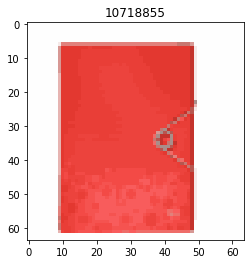

In [139]:
getColorPctPerImage();

################################################### JULIAS CODE ##############################################################

In [ ]:
color_mappings = {
  # source color => arr of colors associated with the source color
    'Grey' : ['Silver', 'Metallic', 'Aluminium', 'Stainless steel', 'Platinum', 'Graphite', 'Chrome', 'Anthracite','Light Grey','Charcoal','Titanium','Light grey'],
    'Purple' : ['Violet', 'Lavender', 'Fuchsia','Magenta'],
    'Transparent' : ['Translucent'],
    'Cream' : ['Beige', 'Sand', 'Tan','Cappuccino','Ivory'],
    'Brown' : ['Oak colour', 'Wood','Bronze'],
    'Cyan' : ['Turquoise', 'Aqua colour'],
    'White' : ['Pearl' ],
    'Pink' : ['Rose'],
    'Red' : ['Cherry', 'Bordeaux'],
    'Green' : ['Pine', 'Lime','Olive'],
    'Yellow' : ['Gold'],
    'Blue' : ['Navy'],
    'Multicolour' : ['Multi','Assorted colours']
}

def colors_binning(initial_color):
    for source_color in color_mappings:
        if initial_color in color_mappings[source_color]: return source_color;
        
    return initial_color;
        
colours = []
with open("datasets/1/colors.txt","r") as file:
    colors = ast.literal_eval(file.read())
    count = 0 
    # lets create a dataframe
    d = {'color': []}
    for row in colors:
        # check if there are more colors in one row
        colors_arr = row[1].split(", ")
        #d['pic_id'].append(row[0])
        d['color'].append(colors_binning(colors_arr[0])) 
        colours.append(colors_binning(colors_arr[0]))

    pic_colors = pd.DataFrame(data=d) #our y/target values
    display(pic_colors)
    # lets see the distribution of colors. We will try to bin the repeating colors to the most common alternatives.
    display(pic_colors.color.value_counts())
    print(count) #number of multiple colour products

In [140]:
def load_image_files(container_path, dimension=(64, 64)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    count_2d = 0
    count_rgb = 0
    count_other = 0
    count_rgba = 0
    count = 0
    img_hash = {}
    for file in image_dir.iterdir():
        #count += 1
        #if count > 10:
         #   break;
        img = plt.imread(file)    
        
        img_pred = cv.resize(img, (50, 50), interpolation=cv.INTER_AREA)
        #plt.imshow(img_pred)
        #img_pred = img_to_array(img_pred)
        img_pred = img_pred / 255
        if img_pred.shape == (50, 50):
            img_pred = cv.cvtColor(img_pred.astype('float32'),cv.COLOR_GRAY2RGB)
        elif img_pred.shape == (50,50,3):
            count_rgb += 1
        elif img_pred.shape == (50,50,4):
            img_pred = cv.cvtColor(img_pred.astype('float32'),cv.COLOR_RGBA2RGB)
        else:
            count_other +=1
            print(img_pred.shape)
            
        images.append(img_pred)
        #img_hash[file.stem] = img_pred
    print("rgb: "+str(count_rgb)+ " 2d: "+str(count_2d)+" rgba: "+str(count_rgba)+ " other: "+str(count_other))
    return images

images_data = load_image_files("datasets/1/images") #our X/data set

rgb: 5776 2d: 0 rgba: 0 other: 0


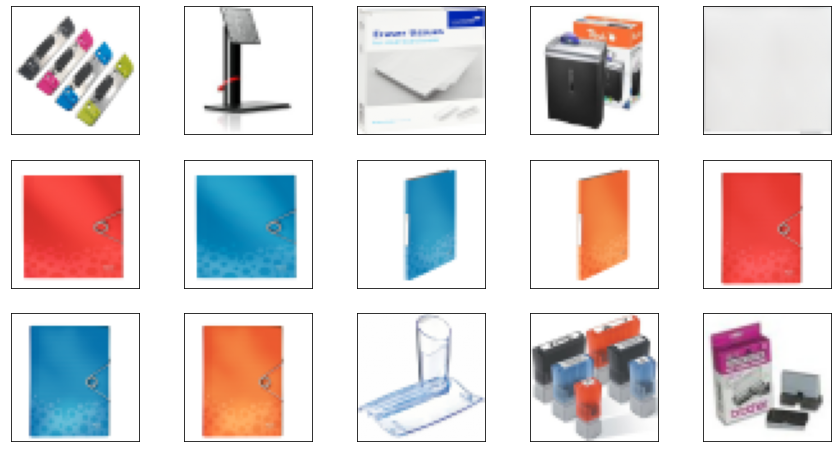

In [141]:
#show some images
fig, axes = plt.subplots(3, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for  image, ax in zip(images_data, axes.ravel()):
    ax.imshow(image)

In [ ]:
#reshape data so it fits 
arr = np.array(images_data)
nsamples, nx, ny, nz = arr.shape
d2_arr = arr.reshape((nsamples,nx*ny*nz))
d2_arr.shape
arr.shape

In [ ]:
# split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    d2_arr, colours, stratify=colours, random_state=69)
# build a KNeighborsClassifier with using one neighbor:
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_train, y_train)
print("Train set score of 5-nn: {:.2f}".format(knn.score(X_train, y_train)))
print("Test set score of 5-nn: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
#lets see how accuracy depends on number of neighbours
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 100)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend(); 

## 2. Flights Departing from NYC

__You should be able to do this exercise after Lecture 4.__

For this exercise we will be using the famous nycflights13 data which contains the `airlines`, `airports`, `flights`, `planes`, and `weather` datasets. Please see the documentation (`nycflights13.pdf`) for further information.

**(a)** Load all files as pandas dataframes and display the first 5 rows of each dataset.

In [184]:
#JULIA
#loading
airlines = pd.read_csv('datasets/2/airlines.csv')
airports = pd.read_csv('datasets/2/airports.csv')
flights = pd.read_csv('datasets/2/flights.csv')
planes = pd.read_csv('datasets/2/planes.csv')
weather = pd.read_csv('datasets/2/weather.csv')
#displaying
display(airlines.head())
display(airports.head())
display(flights.head())
display(planes.head())
display(weather.head())

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.


,faa,name,lat,lon,alt,tz,dst,tzone
0,04G,Lansdowne Airport,41.130472,-80.619583,1044,-5.0,A,America/New_York
1,06A,Moton Field Municipal Airport,32.460572,-85.680028,264,-6.0,A,America/Chicago
2,06C,Schaumburg Regional,41.989341,-88.101243,801,-6.0,A,America/Chicago
3,06N,Randall Airport,41.431912,-74.391561,523,-5.0,A,America/New_York
4,09J,Jekyll Island Airport,31.074472,-81.427778,11,-5.0,A,America/New_York


,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
3,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0
4,2013,1,1,554.0,-4.0,740.0,12.0,UA,N39463,1696,EWR,ORD,150.0,719,5.0,54.0


,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan
1,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
2,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
3,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
4,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z


**(b)** Convert all temperature attributes to degree Celsius. We will be using this in what follows.

In [21]:
#JULIA
weather['temp'] = (weather['temp']-32)*5/9
weather['temp']

0        2.8
1        2.8
2        3.3
3        3.3
4        3.3
        ... 
26125    2.2
26126    1.1
26127    0.0
26128   -0.6
26129   -1.7
Name: temp, Length: 26130, dtype: float64

**(c)** Using OLS, investigate if flight distance is associated with arrival delay. You should be cautious regarding negative delays.

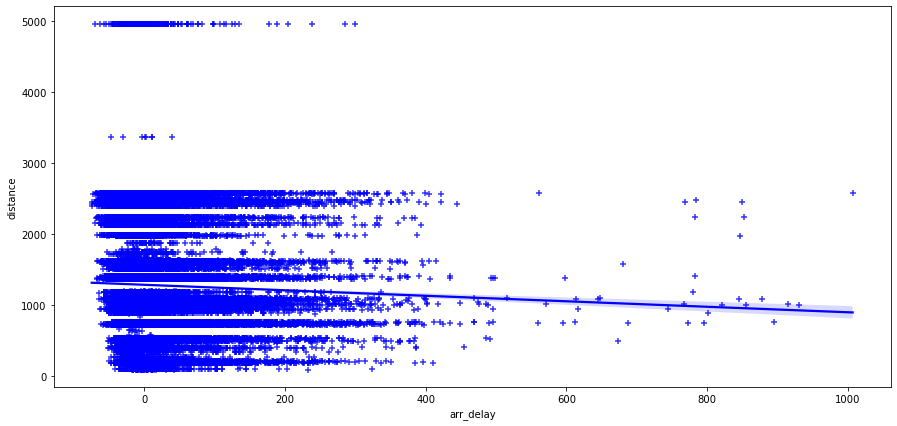

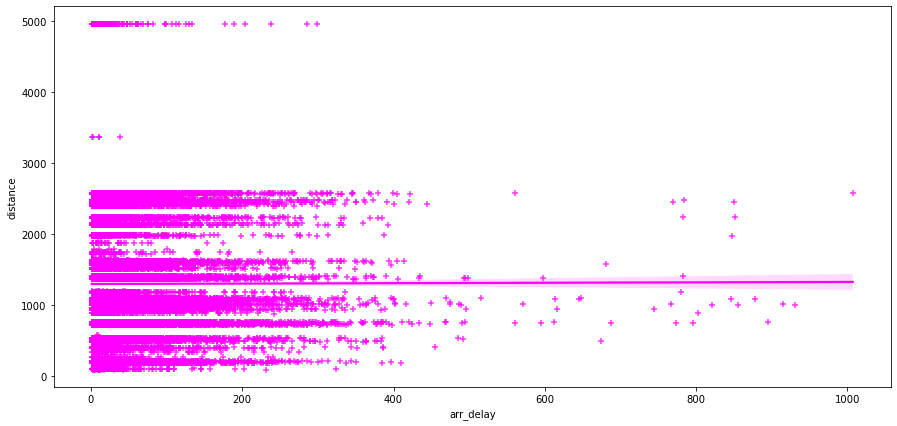

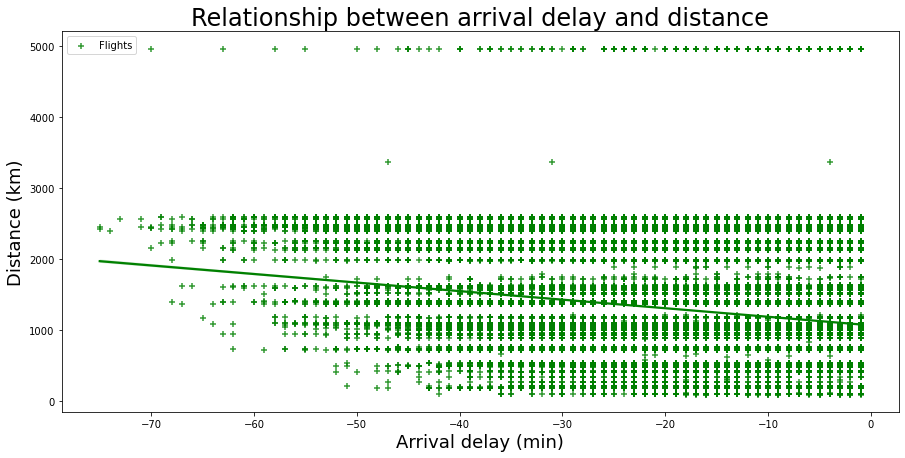

In [22]:
#JULIA

positive_delays = flights[flights['arr_delay']>0]
negative_delays = flights[flights['arr_delay']<0]

# regression plot using seaborn
fig = plt.figure(figsize=(15, 7))
sns.regplot(x=flights.arr_delay, y=flights.distance, color='blue', marker='+')#regression plot for all flights
fig1 = plt.figure(figsize=(15, 7))
sns.regplot(x=positive_delays.arr_delay, y=positive_delays.distance, color='magenta', marker='+')#regression plot for flights with only positive delays
fig2 = plt.figure(figsize=(15, 7))
sns.regplot(x=negative_delays.arr_delay, y=negative_delays.distance, color='green', marker='+')#regression plot for flights with negative delays only 

# Legend, title and labels.
plt.legend(labels=['Flights'])
plt.title('Relationship between arrival delay and distance', size=24)
plt.xlabel('Arrival delay (min)', size=18)
plt.ylabel('Distance (km)', size=18);


According to graphs above the arrival delay and distance have negative correlation almost only in case of negative delays. That means that flights flying further distances were deleyed less(so they arrived sooner) than flights flying short distances, but that's true mostly only for when the flights departed ealier than scheduled(green graph). For flights with regular(positive) delays there's hardly no correlation between delay time and distance(pink graph). Concluding, there's very little correlation between two features and it's mostly influenced by negative delays. 

In [179]:
#to test my conclusions I use corr() function to get correlation score
print(positive_delays[['arr_delay','distance']].corr()) 
#0.001957 - almost none correlation
print(negative_delays[['arr_delay','distance']].corr())
#-0.176971 - weak negative correlation
print(flights[['arr_delay','distance']].corr())
#-0.02094 - very weak negative correlation

           arr_delay  distance
arr_delay   1.000000  0.001957
distance    0.001957  1.000000
           arr_delay  distance
arr_delay   1.000000 -0.176971
distance   -0.176971  1.000000
           arr_delay  distance
arr_delay    1.00000  -0.02094
distance    -0.02094   1.00000


**(d)** Using OLS, investigate if departure delay is associated with arrival delay. Again,
   consider what to do with negative delays.

Text(0.5, 1.0, 'Relationship between arrival delay and negative departure delay')

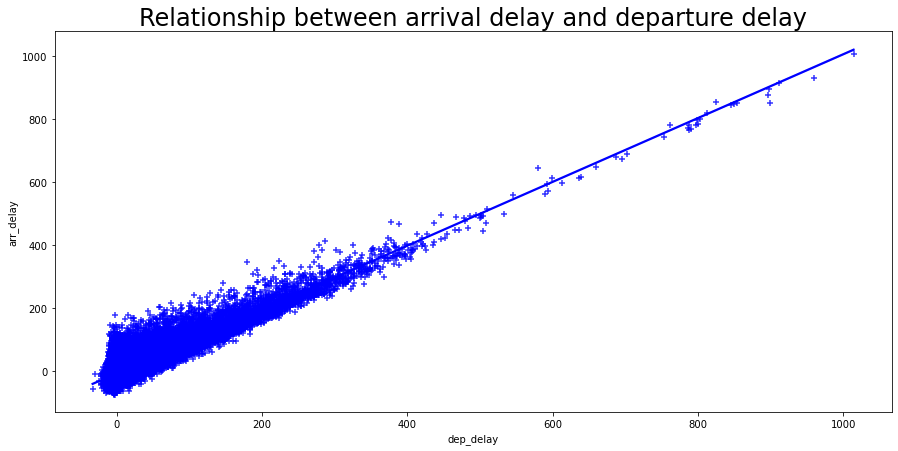

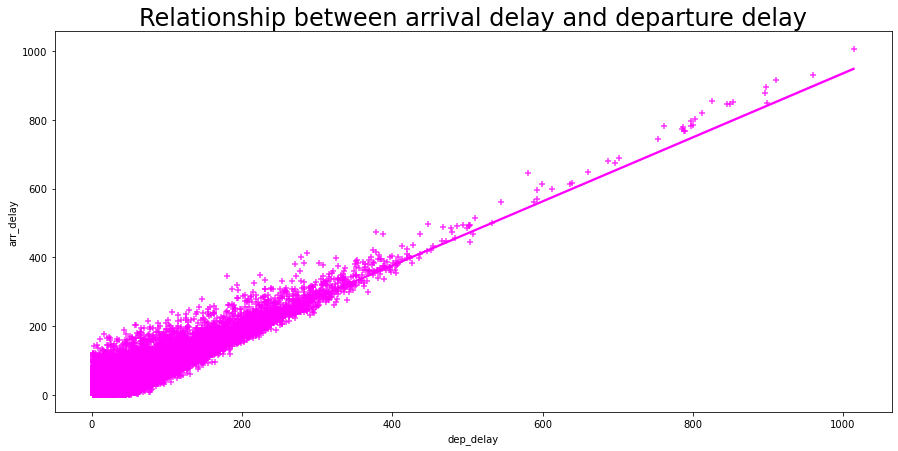

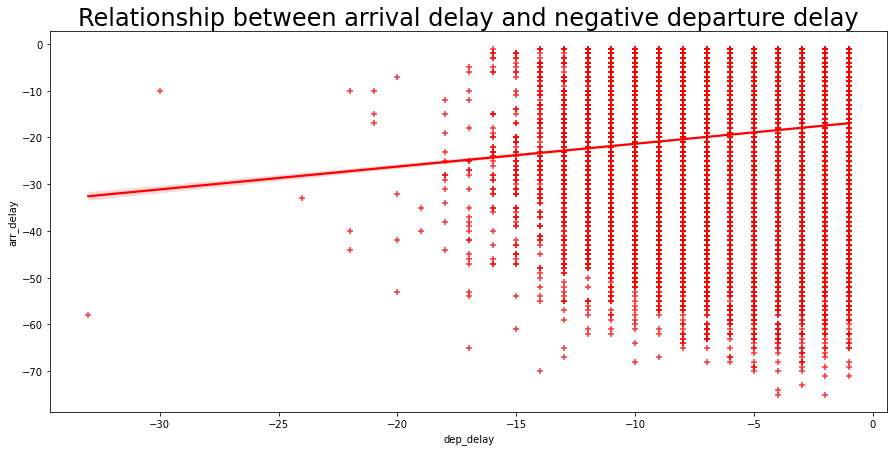

In [23]:
#JULIA

positive_delays = flights[((flights['dep_delay']>0) & (flights['arr_delay']>0))]
negative_delays = flights[((flights['dep_delay']<0) & (flights['arr_delay']<0))]

#all flights
fig = plt.figure(figsize=(15, 7))
sns.regplot(x=flights.dep_delay, y=flights.arr_delay, color='blue', marker='+')
plt.title('Relationship between arrival delay and departure delay', size=24)
#only positive delayed flights(late flights)
fig1 = plt.figure(figsize=(15, 7))
sns.regplot(x=positive_delays.dep_delay, y=positive_delays.arr_delay, color='magenta', marker='+')
plt.title('Relationship between arrival delay and departure delay', size=24)
#only negative delayed flights(that came sooner than expected)
fig2 = plt.figure(figsize=(15, 7))
sns.regplot(x=negative_delays.dep_delay, y=negative_delays.arr_delay, color='red', marker='+') 
plt.title('Relationship between arrival delay and negative departure delay', size=24)



The correlation between departure and arrival time is big in case of late flights but little in case of fligts that departed before expected time. 

In [24]:

print(negative_delays[['arr_delay','dep_delay']].corr())
#0.113862
print(positive_delays[['arr_delay','dep_delay']].corr())
#0.933274
print(negative_arrdelays[['arr_delay','dep_delay']].corr())
#0.225307
print(negative_depdelays[['arr_delay','dep_delay']].corr())
#0.134847

           arr_delay  dep_delay
arr_delay   1.000000   0.113862
dep_delay   0.113862   1.000000
           arr_delay  dep_delay
arr_delay   1.000000   0.933274
dep_delay   0.933274   1.000000


NameError: name 'negative_arrdelays' is not defined

**(e)** Investigate whether departure delay is associated with weather conditions
   at the origin airport. This includes descriptives, plotting, regression modelling,
   considering missing values etc. For regression, do OLS, Ridge, Lasso, and Elastic Net.
   The analysis should also include seasonality trends as a "weather condition". You could,
   for instance, plot the daily departure delay with the date (or monthly). What are the
   three most important weather conditions when trying to predict departure delays?

**(f)** Is the age of the plane associated with delay? Do OLS, Ridge, Lasso, and Elastic Net.

In [185]:
#NIKITA

# DATA PREPARATION 

planes_flights = pd.merge(planes, flights, how='outer', left_on = 'tailnum', right_on = 'tailnum')
planes_flights = planes_flights.drop(['type', 'manufacturer', 'seats', 'model', 'engines', 'speed', 'engine', 'carrier', 'flight', 'origin', 'dest', 'arr_time', 'dep_time', 'air_time', 'distance'], axis=1)
planes_flights['years'] = planes_flights['year_y']-planes_flights['year_x']
planes_flights['delay'] = planes_flights['dep_delay'] + (planes_flights['arr_delay'] - planes_flights['dep_delay'] )
planes_flights = planes_flights.drop(['arr_delay', 'dep_delay', 'year_x', 'year_y', 'month', 'day', 'hour', 'minute'], axis=1)

# taking average delay of each plane

planes_flights = planes_flights.groupby(['tailnum']).mean()
planes_flights = planes_flights.reset_index()
planes_flights = planes_flights.drop(['tailnum'], axis=1)

planes_flights = planes_flights.dropna(subset=['years'])

planes_flights = planes_flights.sort_values(by=['delay'])

#X = result['delay'].array.reshape(-1, 1)
#y = result['years']

#X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [186]:
#now trying to get rid of missing value I'm using regression imputing for it
missing_columns = ["delay"]
#firstly random impute missing values - we have multiple variables with missing values so some predictors woud be nan and it wouldn't work
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

for feature in missing_columns:
    planes_flights[feature + '_imp'] = planes_flights[feature]
    planes_flights = random_imputation(planes_flights, feature)
    
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

#using linear regression to input all the random imputed values with result of lin. regression for each feature with missing values
for feature in missing_columns:
        
    deter_data["Det" + feature] = planes_flights[feature + "_imp"]
    parameters = list(set(planes_flights.columns) - set(missing_columns) - {feature + '_imp'})
    model = LinearRegression()
    model.fit(X = planes_flights[parameters], y = planes_flights[feature + '_imp'])
    deter_data.loc[planes_flights[feature].isnull(), "Det" + feature] = model.predict(planes_flights[parameters])[planes_flights[feature].isnull()]
    planes_flights[feature] = deter_data["Det" + feature]
    planes_flights = planes_flights.drop(columns=[feature + "_imp"])
    

planes_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1714 entries, 2012 to 3597
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   years   1714 non-null   float64
 1   delay   1714 non-null   float64
dtypes: float64(2)
memory usage: 40.2 KB


In [187]:
# Correlation of years/delay

print(planes_flights[['years','delay']].corr())

          years     delay
years  1.000000  0.080981
delay  0.080981  1.000000


In [188]:
def plotRegression(X_train,y_train):
    plt.scatter(X_train, y_train, color='red') # plotting the observation line
    plt.plot(X_train, lr.predict(X_train), color='blue') # plotting the regression line
    plt.title("(Training set)") # stating the title of the graph
    plt.xlabel("Delay") # adding the name of x-axis
    plt.ylabel("Ages") # adding the name of y-axis
    plt.show() # specifies end of graph

lr.coef_: [0.01743494]
lr.intercept_: 15.293392138778685
Training set score (R2): 0.002115
Test set score: 0.006083
Difference in training and test set score signs of overfiting


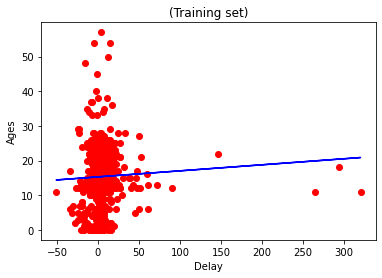

In [189]:
## OLS

X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("Training set score (R2): {:.6f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.6f}".format(lr.score(X_test, y_test)))
print('Difference in training and test set score signs of overfiting')

## making graph
plotRegression(X_train,y_train)

In [190]:
#Ridge
alphas = 10**np.linspace(-10, 10, 100)
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

np.shape(coefs)
_coefficients = [coef[0] for coef in coefs]

C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

Text(0, 0.5, 'weights')

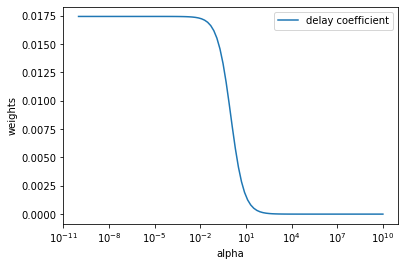

In [191]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, _coefficients, label="delay coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

1.0
R^2 on train data is 0.0015859749262949752 and on test data is 0.001968746431989632  


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


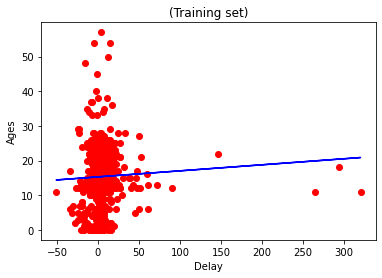

In [192]:
X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

ridgecv = RidgeCV(normalize = True)#alphas = alphas,
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)   
print("R^2 on train data is {} and on test data is {}  ".format(ridgecv.score(X_train, y_train), ridgecv.score(X_test,y_test)))

## making graph
plotRegression(X_train,y_train)

Training set score: 0.000796
Test set score: -0.000790
Number of features used: 1


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


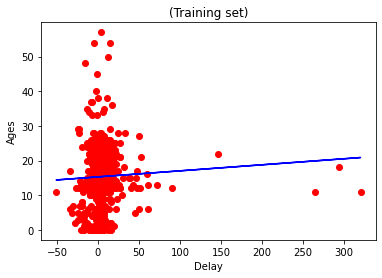

In [193]:
#Lasso
X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

#we increase the default setting of "max_iter",
#otherwise the model would warn us that we should increase max_iter.
lasso = Lasso(alpha=0.01, max_iter=10000, normalize = True).fit(X_train, y_train)
print("Training set score: {:.6f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.6f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

## making graph
plotRegression(X_train,y_train)

0.0126639158033658
R^2 on train data is 0.0 and on test data is -0.0029671335273051547


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


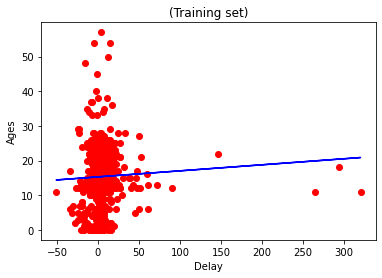

In [194]:
#LassoCV
X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)#alphas = None,
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))

## making graph
plotRegression(X_train,y_train)

alpha: 78.830873
l1_ratio_: 0.100000
R^2 on train data is 0.0 and on test data is -0.0029671335273051547


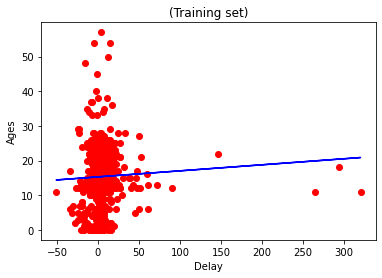

In [196]:
# ElasticNet
X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=69)
ratios = [.1, .2, .3 , .4, .5, .7, .8, .9, .95, .99, 1]
#alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
en = ElasticNetCV(l1_ratio=ratios, cv=10, n_jobs=-1)
en.fit(X_train, y_train)

print('alpha: %f' % en.alpha_)
print('l1_ratio_: %f' % en.l1_ratio_)
print("R^2 on train data is {} and on test data is {}".format(en.score(X_train, y_train),en.score(X_test,y_test)))

## making graph
plotRegression(X_train,y_train)




**(g)** Do a principal component analysis of the weather at JFK using the following columns:
   temp, dewp, humid, wind_dir, wind_speed, precip, visib.
   How many principal components should be used to capture the variability in the weather data?

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26125,LGA,2013,12,30,19,35.96,19.94,51.78,340.0,13.80936,15.891535,0.0,1017.1,10.0,2013-12-30T19:00:00Z
26126,LGA,2013,12,30,20,33.98,17.06,49.51,330.0,17.26170,19.864419,0.0,1018.8,10.0,2013-12-30T20:00:00Z
26127,LGA,2013,12,30,21,32.00,15.08,49.19,340.0,14.96014,17.215830,0.0,1019.5,10.0,2013-12-30T21:00:00Z
26128,LGA,2013,12,30,22,30.92,12.92,46.74,320.0,17.26170,19.864419,0.0,1019.9,10.0,2013-12-30T22:00:00Z


array([[37.04   , 21.92   , 53.97   , ..., 10.35702,  0.     , 10.     ],
       [37.04   , 21.92   , 53.97   , ..., 13.80936,  0.     , 10.     ],
       [37.94   , 21.92   , 52.09   , ..., 12.65858,  0.     , 10.     ],
       ...,
       [32.     , 15.08   , 49.19   , ..., 14.96014,  0.     , 10.     ],
       [30.92   , 12.92   , 46.74   , ..., 17.2617 ,  0.     , 10.     ],
       [28.94   , 10.94   , 46.41   , ..., 18.41248,  0.     , 10.     ]])

array(['EWR', 'EWR', 'EWR', ..., 'LGA', 'LGA', 'LGA'], dtype=object)

variance explained by all 7 principal components = 100.0
variance explained by the First principal component = 34.44166410062209
variance explained by the 2 principal component = 56.61927524418124
variance explained by the 3 principal component = 72.21257346879489
variance explained by the 4 principal component = 82.84070332775293
variance explained by the 5 principal component = 92.96747389582134
variance explained by the 6 principal component = 99.96106204289795
variance explained by the 7 principal component = 100.0


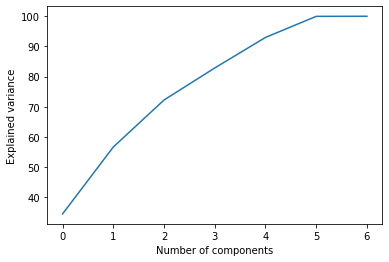

In [197]:
# Nikita 
features = ['temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'precip', 'visib']
weather_to_use = weather.dropna()

display(weather_to_use)

# Separating out the features
X = weather_to_use.loc[:, features].values
display(X)
# Separating out the origin
y = weather_to_use['origin'].values
display(y)
# Splitting the X and Y into the
sc = StandardScaler()
# Standardizing the features
sc.fit(X)
X_scaled = sc.transform(X)

# Applying PCA 
# 7 components sa the number of features we have
pca = PCA(n_components = 7)
pca.fit(X_scaled)
X_pca_7 = pca.transform(X_scaled)

print("variance explained by all 7 principal components =", sum(pca.explained_variance_ratio_ * 100))

plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('elbow_plot.png', dpi=100)

print("variance explained by the First principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[0])

print("variance explained by the 2 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[1])

print("variance explained by the 3 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[2])

print("variance explained by the 4 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[3])

print("variance explained by the 5 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[4])

print("variance explained by the 6 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[5])

print("variance explained by the 7 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[6])

# It is not possible to create a scatterplot for the original datase because it contains 7 features.
# We can make 2D and 3D scatterplots, but in this case we will lose some variability
# For 2D scatterplot we will have 56.6...% variability
# For 3D scatterplot we will have 72.2...% variability 

# Variance after 5 porincipal componenet are not changing significantlty 

# Select the best number of principal components while keeping as much of the variance in the original data as possible.

# We can choose 5 prncipal components to capture the variability in the weather data


**(h)** Build regression models (OLS, Ridge, Lasso, and Elastic Net) that associates
   an airports lattitude with weather conditions (temp, dewp, humid, wind_dir, wind_speed,
   precip, visib). Remove all but the three most significant whether conditions and redo
   the analysis.

In [198]:
# Nikita 
# Data Preparation
data = pd.merge(airports, weather, how='outer', left_on = 'faa', right_on = 'origin')
data = data.drop(columns = ['year', 'month', 'day', 'hour','lon', 'alt', 'tz', 'dst', 'tzone', 'origin', 'name', 'time_hour', 'pressure', 'wind_gust', 'faa'])
display(data)
data = data.dropna(subset=['lat'])
data = data[data["wind_speed"] < 1000]


,lat,temp,dewp,humid,wind_dir,wind_speed,precip,visib
0,41.130472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32.460572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41.989341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41.431912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31.074472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
27580,35.083228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27581,41.298669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27582,39.736667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27583,38.897460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
#now trying to get rid of missing value I'm using regression imputing for it
missing_columns = ["temp", "dewp", "humid", "wind_dir", "wind_speed","precip","visib"]
#firstly random impute missing values - we have multiple variables with missing values so some predictors woud be nan and it wouldn't work

for feature in missing_columns:
    data[feature + '_imp'] = data[feature]
    data = random_imputation(data, feature)
    
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

#using linear regression to input all the random imputed values with result of lin. regression for each feature with missing values
for feature in missing_columns:
        
    deter_data["Det" + feature] = data[feature + "_imp"]
    parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imp'})
    model = LinearRegression()
    model.fit(X = data[parameters], y = data[feature + '_imp'])
    deter_data.loc[data[feature].isnull(), "Det" + feature] = model.predict(data[parameters])[data[feature].isnull()]
    data[feature] = deter_data["Det" + feature]
    data = data.drop(columns=[feature + "_imp"])
    

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26126 entries, 460 to 26913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         26126 non-null  float64
 1   temp        26126 non-null  float64
 2   dewp        26126 non-null  float64
 3   humid       26126 non-null  float64
 4   wind_dir    26126 non-null  float64
 5   wind_speed  26126 non-null  float64
 6   precip      26126 non-null  float64
 7   visib       26126 non-null  float64
dtypes: float64(8)
memory usage: 1.8 MB


In [200]:
# OLS 

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
lr = LinearRegression()
lr.fit(X_train, y_train)

print("R^2 on train data is {} and on test data is {}".format(lr.score(X_train, y_train),lr.score(X_test,y_test)))
print("the intercept is {}".format(lr.intercept_))
pd.Series(lr.coef_, index=X.columns)
    

R^2 on train data is 0.036772442089002655 and on test data is 0.03430171066210408
the intercept is 40.91798915354982


temp         -0.003257
dewp          0.003584
humid        -0.002274
wind_dir     -0.000015
wind_speed   -0.000874
precip        0.021463
visib        -0.003199
dtype: float64

In [201]:
def plotOLSRegression(feature, data):
    X = data[[feature]]
    y = data['lat']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(lr.score(X_train, y_train),lr.score(X_test,y_test)))
    print(data[['lat',feature]].corr())
    
    y_pred = lr.predict(X)
    plt.scatter(X,y,color = "green") 
    plt.plot(X[feature], y_pred,color = "blue")
    plt.xlabel(feature)
    plt.ylabel("Lat")
    plt.show()

R^2 on train data is 1.0 and on test data is 1.0
     lat  lat
lat  1.0  1.0
lat  1.0  1.0


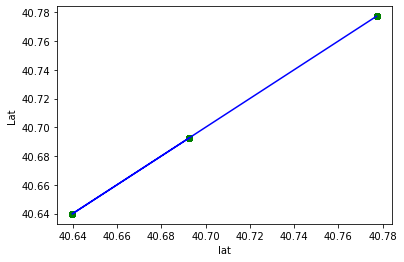

R^2 on train data is 0.0003006806333113454 and on test data is 0.000946740487588138
           lat      temp
lat   1.000000  0.027729
temp  0.027729  1.000000


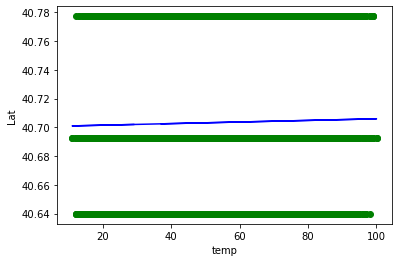

R^2 on train data is 0.0014076241944321888 and on test data is -8.825178977978076e-05
          lat     dewp
lat   1.00000 -0.02807
dewp -0.02807  1.00000


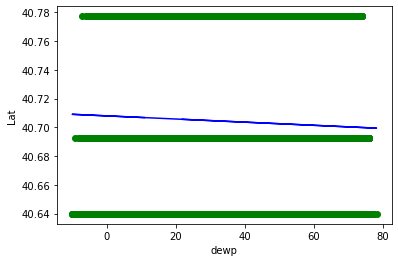

R^2 on train data is 0.01654872440362043 and on test data is 0.01564968794000532
            lat     humid
lat    1.000000 -0.127012
humid -0.127012  1.000000


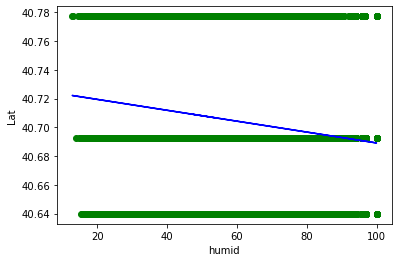

R^2 on train data is 0.00013014634571029138 and on test data is 0.0002301909334208041
              lat  wind_dir
lat       1.00000  -0.01528
wind_dir -0.01528   1.00000


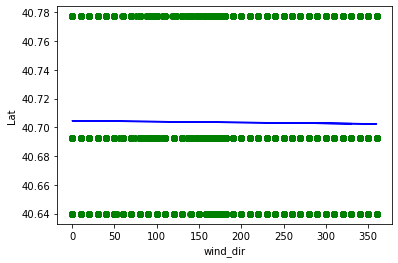

R^2 on train data is 0.0022143012026115683 and on test data is 0.001331732089351445
                 lat  wind_speed
lat         1.000000   -0.042797
wind_speed -0.042797    1.000000


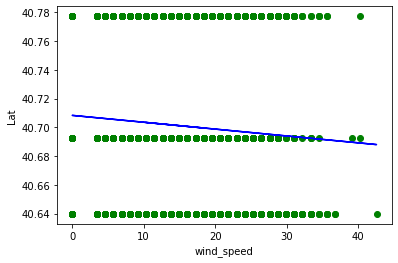

R^2 on train data is 0.00027497813132371096 and on test data is -0.0003448459657260372
             lat    precip
lat     1.000000 -0.008406
precip -0.008406  1.000000


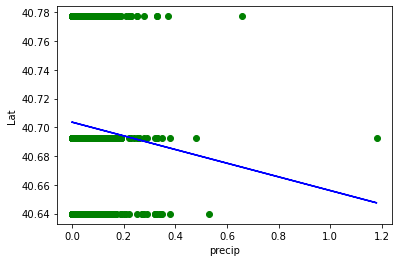

R^2 on train data is 0.0006498284126313925 and on test data is 0.0004010566011162231
            lat     visib
lat    1.000000  0.023828
visib  0.023828  1.000000


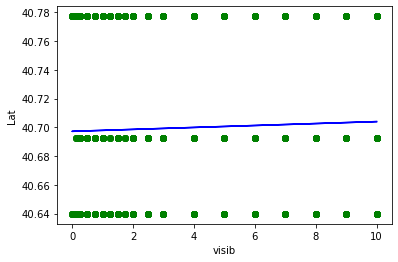

In [202]:
#OLS

for feature in data.columns:
    plotOLSRegression(feature,data)

In [203]:
#Ridge

alphas = 10**np.linspace(-10, 10, 100)

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
temp_coefficients = [coef[0] for coef in coefs]
dewp_coefficients = [coef[1] for coef in coefs]
humid_coefficients = [coef[2] for coef in coefs]
wind_dir_coefficients = [coef[3] for coef in coefs]
wind_speed_coefficients = [coef[4] for coef in coefs]
precip_coefficients = [coef[5] for coef in coefs]
visib_coefficients = [coef[6] for coef in coefs]

C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

Text(0, 0.5, 'weights')

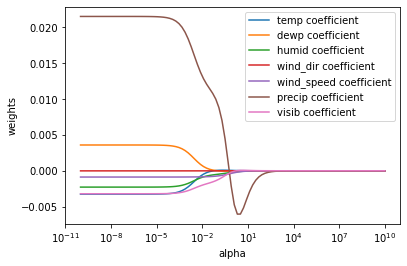

In [204]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, temp_coefficients, label="temp coefficient")
ax.plot(alphas, dewp_coefficients, label="dewp coefficient")
ax.plot(alphas, humid_coefficients, label="humid coefficient")
ax.plot(alphas, wind_dir_coefficients, label="wind_dir coefficient")
ax.plot(alphas, wind_speed_coefficients, label="wind_speed coefficient")
ax.plot(alphas, precip_coefficients, label="precip coefficient")
ax.plot(alphas, visib_coefficients, label="visib coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [205]:
#RidgeCV

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

ridgecv = RidgeCV(normalize = True)
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)   
print("R^2 on train data is {} and on test data is {}  ".format(ridgecv.score(X_train, y_train), ridgecv.score(X_test,y_test)))
pd.Series(ridgecv.coef_, index = X.columns)

0.1
R^2 on train data is 0.027829241148976225 and on test data is 0.02689405649751553  


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


temp          0.000056
dewp          0.000004
humid        -0.000493
wind_dir     -0.000013
wind_speed   -0.000726
precip        0.009374
visib        -0.001277
dtype: float64

In [206]:
#Lasso

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
lasso = Lasso(alpha = 8.3,max_iter = 10000, normalize = True)#alphas = None,
lasso.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format(lasso.score(X_train, y_train),lasso.score(X_test,y_test)))

R^2 on train data is 0.0 and on test data is -7.807372411261504e-05


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [211]:
#LassoCV

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)#alphas = None,
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))

pd.Series(lassocv.coef_, index=X.columns)

6.382816015389213e-08
R^2 on train data is 0.03675505231482945 and on test data is 0.0343523444503262


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


temp         -0.003104
dewp          0.003420
humid        -0.002195
wind_dir     -0.000015
wind_speed   -0.000871
precip        0.020659
visib        -0.003129
dtype: float64

In [212]:
# Elastic Net CV

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=69)
ratios = [.1, .2, .3 , .4, .5, .7, .8, .9, .95, .99, 1]
#alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
en = ElasticNetCV(l1_ratio=ratios, cv=10, n_jobs=-1)
en.fit(X_train, y_train)
print('alpha: %f' % en.alpha_)
print('l1_ratio_: %f' % en.l1_ratio_)
print("R^2 on train data is {} and on test data is {}".format(en.score(X_train, y_train),en.score(X_test, y_test)))
pd.Series(en.coef_, index=X.columns)

alpha: 0.000141
l1_ratio_: 1.000000
R^2 on train data is 0.036693578936447424 and on test data is 0.034158844884496053


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.733e-01, tolerance: 4.201e-03
  model = cd_fast.enet_coordinate_descent(


temp         -0.003058
dewp          0.003370
humid        -0.002168
wind_dir     -0.000015
wind_speed   -0.000858
precip        0.000000
visib        -0.003124
dtype: float64

In [215]:
# Remove all but the three most significant whether conditions and redo the analysis.
# temp, dewp, humid, wind_dir, wind_speed, precip, visib

# dewp, precip, visib have more significant change after doing ElasticNetCV 

data_upd = data.drop(['temp', 'wind_speed', 'humid', 'wind_dir'], axis=1)

data_upd



X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


lr.coef_: [ 5.89285645e-06 -5.01849477e-04 -1.57217130e-02]
lr.intercept_: 40.707456834702036
Training set score: 0.002233
Test set score: 0.001244


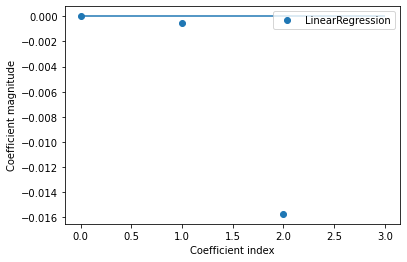

In [210]:
#OLS
X = data_upd.loc[:,'dewp':'visib']
y = data_upd['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
lr = LinearRegression()
lr.fit(X_train, y_train)

print("R^2 on train data is {} and on test data is {}".format(lr.score(X_train, y_train),lr.score(X_test,y_test)))
print("the intercept is {}".format(lr.intercept_))
pd.Series(lr.coef_, index=X.columns)

R^2 on train data is 1.0 and on test data is 1.0
     lat  lat
lat  1.0  1.0
lat  1.0  1.0


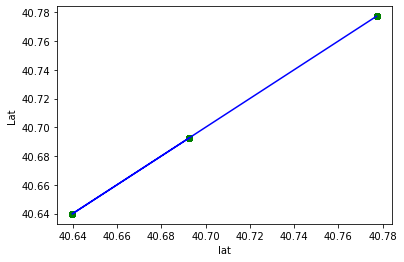

R^2 on train data is 0.0014076241944321888 and on test data is -8.825178977978076e-05
          lat     dewp
lat   1.00000 -0.02807
dewp -0.02807  1.00000


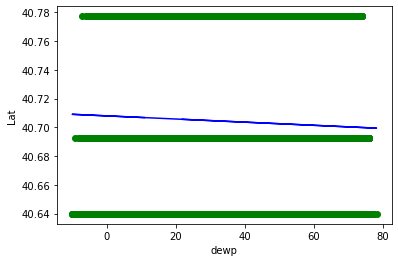

R^2 on train data is 0.00027497813132371096 and on test data is -0.0003448459657260372
             lat    precip
lat     1.000000 -0.008406
precip -0.008406  1.000000


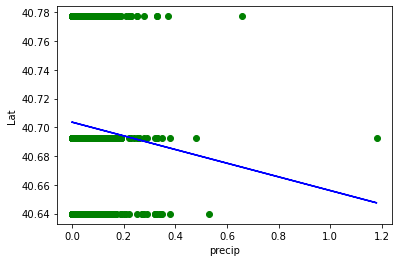

R^2 on train data is 0.0006498284126313925 and on test data is 0.0004010566011162231
            lat     visib
lat    1.000000  0.023828
visib  0.023828  1.000000


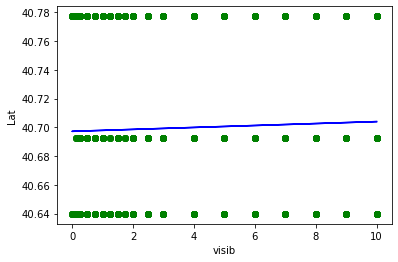

In [217]:
for feature in data_upd.columns:
    plotOLSRegression(feature,data_upd)

In [218]:
#Ridge

X = data_upd.loc[:,'dewp':'visib']
y = data_upd['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

ridgecv = RidgeCV(normalize = True)
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)   
print("R^2 on train data is {} and on test data is {}  ".format(ridgecv.score(X_train, y_train), ridgecv.score(X_test,y_test)))
pd.Series(ridgecv.coef_, index = X.columns)


0.1
R^2 on train data is 0.0018870286323965368 and on test data is 0.00023426994627806508  


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


dewp     -0.000092
precip   -0.023997
visib     0.000447
dtype: float64

In [219]:
#Lasso

X = data_upd.loc[:,'dewp':'visib']
y = data_upd['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)#alphas = None,
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))

pd.Series(lassocv.coef_, index=X.columns)


9.934503179527345e-08
R^2 on train data is 0.0018985733263088278 and on test data is 0.00013044671863027268


C:\Users\themr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


dewp     -0.000100
precip   -0.024349
visib     0.000475
dtype: float64

In [220]:
# Elastic Net
X = data_upd.loc[:,'dewp':'visib']
y = data_upd['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=69)
ratios = [.1, .2, .3 , .4, .5, .7, .8, .9, .95, .99, 1]
#alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
en = ElasticNetCV(l1_ratio=ratios, cv=10, n_jobs=-1)
en.fit(X_train, y_train)
print('alpha: %f' % en.alpha_)
print('l1_ratio_: %f' % en.l1_ratio_)
print("R^2 on train data is {} and on test data is {}".format(en.score(X_train, y_train),en.score(X_test, y_test)))
pd.Series(en.coef_, index=X.columns)



alpha: 0.000414
l1_ratio_: 0.100000
R^2 on train data is 0.0018317097277502636 and on test data is 0.0003187633337481399


dewp     -0.000101
precip   -0.000000
visib     0.000543
dtype: float64

**(i)** On a map, plot the airports that have flights to them where the points that represent
   airports are relative in size to the average departure delay. You can see an example in "airports.png".

In [ ]:
# Nikita

data_map = pd.merge(airports, flights, how='outer', left_on = 'faa', right_on = 'dest')
data_map = data_map.dropna()

data_map = data_map.drop(['dep_time', 'arr_time', 'arr_delay', 'carrier', 'tailnum', 'flight', 'origin', 'dest', 'air_time', 'distance', 'tzone', 'tz', 'alt', 'name', 'faa', 'hour', 'minute', 'year', 'month', 'day', 'dst'], axis=1)

data_map = data_map.groupby(['lat', 'lon']).mean()

data_map = data_map.reset_index()

positive_delays = data_map[(data_map['dep_delay']>0)]

geometry = [Point(xy) for xy in zip(positive_delays['lon'], positive_delays['lat'])]
gdf = GeoDataFrame(positive_delays, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=positive_delays['dep_delay'])





 **(j)** These questions require no code.
 - Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter or reduce it?

- Why would you want to use:
        > Ridge Regression instead of plain Linear Regression (i.e. without any regularization)?
        > Lasso instead of Ridge Regression?
        > Elastic Net instead of Lasso?

In [ ]:
# Nikita
# Suppose you are using Ridge Regression and you notice that the training error and the validation 
# error are almost equal and fairly high. Would you say that the model suffers from high bias or high 
# variance? Should you increase the regularization hyperparameter or reduce it?

# When the training error and validation error are close to each other and high that means your model 
# is underfitting (i.e. it has high bias). You should try to reduce the regularization hyperparameter.

In [ ]:
#Why would you want to use:

#Ridge Regression instead of plain Linear Regression (i.e. without any regularization)?

#When you have features in your dataset that are highly linearly correlated with other features, 
#turns out linear models will be likely to overfit. Ridge Regression, avoids over fitting 
#by adding a penalty to models that have too large coefficients.

#Lasso instead of Ridge Regression?

#Lasso tends to do well if there are a small number of significant parameters and the others 
#are close to zero.

# Elastic Net instead of Lasso?

#Elastic Net combines feature elimination from Lasso and feature coefficient reduction from 
#the Ridge model to improve your model's predictions.


## 3. Clustering of Handwritten Digits

__You should be able to do this exercise after Lecture 5.__

This exercise will depart from the famous MNIST dataset, and we are exploring several clustering techniques with it.. This is a ".mat" file, in order to load this file in an ipynb you have to use loadmat() function from scipy.io. (replace my path).

In [3]:
from scipy.io import loadmat
mnist = loadmat('datasets/3/mnist-original')
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]
display(mnist_label)
import numpy as np
print("Number of datapoints: {}\n".format(mnist_data.shape[0]))
print("Number of features: {}\n".format(mnist_data.shape[1]))
print("List of labels: {}\n".format(len(np.unique(mnist_label))))

array([0., 0., 0., ..., 9., 9., 9.])

Number of datapoints: 70000

Number of features: 784

List of labels: 10



There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels,
and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s `imshow()` function:

Value of datapoint no. 11000:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  33 225 255 113   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 129 253 253 172   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   5 191 253 253 172   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   5 136 253 253 

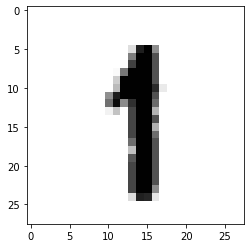

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
index = 11000
print("Value of datapoint no. {}:\n{}\n".format(index,mnist_data[index]))
print("As image:\n")
plt.imshow(mnist_data[index].reshape(28,28),cmap=plt.cm.gray_r)
plt.show()

**(a)** Perform k-means clustering with k=10 on this dataset.

In [5]:
counts = np.bincount(mnist_label.astype(int))
for i, (count, number) in enumerate(zip(counts, np.unique(mnist_label))):
    print("{0:25} {1:3}".format(number, count), end =' ')
    if (i + 1) % 3 == 0:
        print()

                      0.0 6903                       1.0 7877                       2.0 6990 
                      3.0 7141                       4.0 6824                       5.0 6313 
                      6.0 6876                       7.0 7293                       8.0 6825 
                      9.0 6958 

In [6]:
mask = np.zeros(mnist_label.shape, dtype=np.bool)
for target in np.unique(mnist_label):
    mask[np.where(mnist_label == target)[0][:6313]] = 1
    
X_number = mnist_data[mask]
y_number = mnist_label[mask]

X_number = X_number / 255

C:\Users\themr\AppData\Local\Temp\ipykernel_13096\1524841141.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(mnist_label.shape, dtype=np.bool)


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X_number, y_number, stratify=y_number, random_state=0)

In [145]:
#pca = PCA(n_components = 0.90, whiten=True, random_state=0).fit(X_train)
#X_train_pca = pca.transform(X_train)
#X_test_pca = pca.transform(X_test)

#print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (47347, 88)


In [149]:
from sklearn.cluster import KMeans

**(b)** Using visualization techniques analogous to what we have done in the Clustering notebook
   for the faces data, can you determine the 'nature' of the 10 constructed clusters?
   Do the clusters (roughly) coincide with the 10 different actual digits?

**(c)** Perform a supervised clustering evaluation using adjusted rand index.
   Are the results stable, when you perform several random restarts of k-means?

**(d)** Now perform hierarchical clustering on the data.
   (in order to improve visibility in the constructed dendrograms, you can also use a
   much reduced dataset as constructed using sklearn.utils.resample shown below).
   Does the visual analysis of the dendrogram indicate a natural number of clusters?

**(e)** Using different cluster distance metrics (ward,single,average, etc.),
   what do the clusterings look like that are produced at the level of k=10 clusters?
   See the Clustering notebook for the needed Python code, including the fcluster
   method to retrieve 'plain' clusterings from the hierarchical clustering.

In [ ]:
small_mnist_data,small_mnist_label = skl.utils.resample(mnist.data,mnist.target,n_samples=200,replace='false')

**(f)** Do a DBSCAN clustering of the small dataset. Tweak the different parameters.

In [173]:
def plotCluster(clusters, X_scaled):
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, s=60)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    print("Unique groups: {}".format(np.unique(clusters)))

In [174]:
from sklearn.datasets import make_moons, make_blobs
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=200, noise=0.07, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [175]:
# parameters
# epsilon - local radius for expanding clusters
# min_samples - the fewest number of points required to form a cluster
# unique groups show an array of unique formed groups. If array containing -1 number, means there is noise. 


Unique labels: [0]


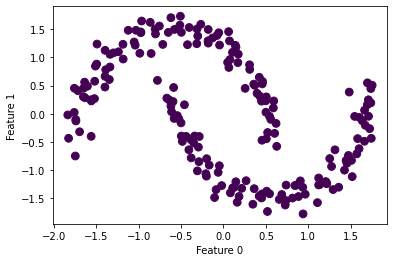

In [176]:
# DBSCAN clustering without parameters / default epsilon is 0.5 and min_samples are 4
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)


In [177]:
# Epsilon 0.5 is too big. So it's forming only one group 

Unique labels: [-1  0  1]


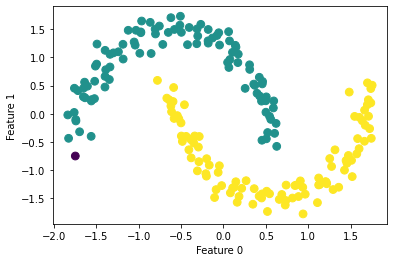

In [178]:
# DBSCAN clustering with eps 0.3 and default min_samples = 4
dbscan = DBSCAN(eps = 0.3)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [179]:
# Now it's possible to see two groups and one sample of noise. 

Unique labels: [0 1]


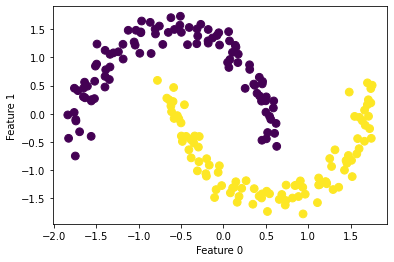

In [180]:
# DBSCAN clustering with eps 0.4 and min_samples = 3
dbscan = DBSCAN(eps = 0.4, min_samples = 3)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [181]:
# With eps 0.4 and min_sample 3 we can see two groups

Unique labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


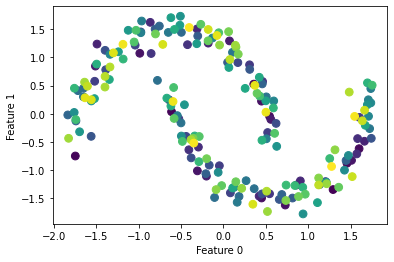

In [182]:
# DBSCAN clustering with eps 0.01 and min_samples = 1
dbscan = DBSCAN(eps = 0.01, min_samples = 1)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [160]:
X, y = make_blobs(random_state=0, n_samples=100)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
# With low eps 0.01 and minimum sample to form group we can see that each sample form it's own group

Unique labels: [-1  0  1]


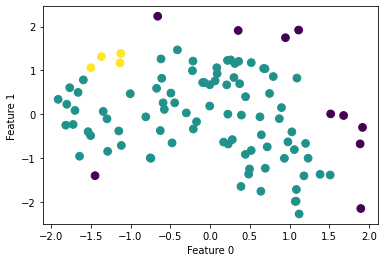

In [165]:
# DBSCAN clustering with default parameters on blob map
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [ ]:
# In this example we can see 2 groups and noise.

Unique labels: [-1  0  1]


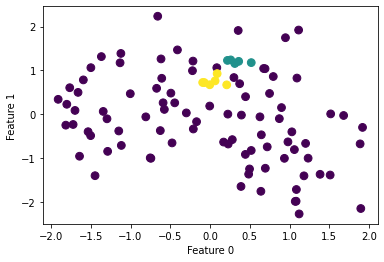

In [166]:
# DBSCAN clustering with eps 0.2
dbscan = DBSCAN(eps = 0.2)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [ ]:
# After decresing eps value we have two small groups and a lot of noise areound. Epsilon is to small so the radius distance is not enough to form groups.

Unique labels: [-1  0]


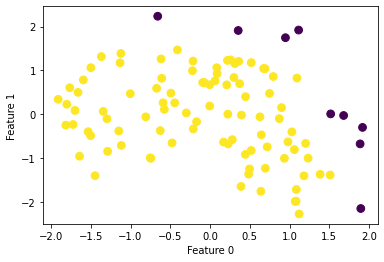

In [167]:
# DBSCAN clustering with eps 0.6
dbscan = DBSCAN(eps = 0.6)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [ ]:
# After incresing epsilon, it is possible to see one big group with the noise around.

Unique labels: [0 1 2 3 4 5]


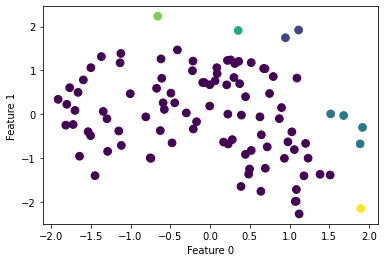

In [171]:
# DBSCAN clustering with eps 0.6 and min_samples = 1
dbscan = DBSCAN(eps = 0.6, min_samples = 1)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [ ]:
# Now I decreased number of samples to form group to one. Now we have 5 groups and no noise

**(g)** Try to compare the different clustering methods on the MNIST dataset in the same way
   the book does on the faces dataset on pp. 195-206.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_number)
X_pca = pca.transform(X_number)

# apply DBSCAN with default parameters

#dbscan = DBSCAN(min_samples=3, eps=15)
#labels = dbscan.fit_predict(X_pca)
#print("Unique labels: {}".format(np.unique(labels)))

# Count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# The first number in the result corresponds to noise points.
# print("Number of points per cluster: {}".format(np.bincount(labels + 1)))




## 4. The Local Elections

__You should be able to do this exercise after Lecture 6.__

In the local elections of 2021, around 100 candidates stood for election for the city council of Horsens. 83 of them represented a national party, had more than one candidate and provided answers to the <a href="https://www.dr.dk/nyheder/politik/kandidattest">DR Candidate Test</a>, a test designed to help voters find out who they should vote for. In this test, the candidates answered 18 questions, which we will use as features in the following. The politicians belong to 9 parties, which will be our classes.

The numpy files `X_Horsens.npy` and `Y_Horsens.npy` contains the data. `Y_Horsens.npy` contains a letter representing the party to which each candidate belongs. The following parties are represented:

| Party letter | Party name | Party name (English) | Political position | Party color |
| :-: | :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left | Red |
| B | Radikale Venstre | Social Liberal Party | Centre-left | Indigo |
| C | Det Konservative Folkeparti | Conservative People's Party | Right-wing | Green |
| D | Nye Borgerlige | New Right | Far-right | Black |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing | Fuchsia |
| I | Liberal Alliance | Liberal Alliance | Right-wing | Cyan |
| O | Dansk Folkeparti | Danish People's Party | Far-right | Yellow |
| V | Venstre | Danish Liberal Party | Centre-right | Blue |
| Z* | Enhedslisten | Red-Green Alliance | Far-left | Dark red |

*_Note that, although the party letter of Enhedslisten is actually Ø, we will here use Z to avoid any complications with the wonderful Danish letters Æ, Ø and Å. Feel free to change the Z back to an Ø if you find that it does not cause any problems._

Meanwhile, `X_Horsens.npy` contains the answers to the test as numbers between -1.5 and 1.5, such that -1.5 is "Strongly disagree", -0.5 is "Disagree", 0.5 is "Agree" and 1.5 is "Strongly agree". The 18 questions concern, in order, subdivision, schools, windmills, building permits, tall buildings, housing, child care, culture, nursing homes, taxes, sports, refugees, nursing homes (again), public transportation, meat-free days, welfare, privatization, and religious minorities.

Both files can be imported using `numpy.load`.

__(a)__ How well do you (intuitively) expect that we can predict the partisan affiliation of a candidate based on their answers to the test?

__(b)__ Based on the answers from all 83 candidates for the Horsens city council, perform a Principal Component Analysis with 2 principal components. Plot the results in a figure using these 2 components as the axes. Label the points with the party letter and the appropriate color.

__(c)__ Comment on the results. You may consider the following questions for inspiration: Can the political parties be separated? Can the typical distinction of "left-wing" and "right-wing" be discerned? Which of the 18 questions (features) are most important?

The number of candidates (83) is on the (very) low side when we want to do machine learning. Luckily, the neighbouring city of Databorg had no less than 8,300 candidates standing for election, with a political environment similar to that of Horsens. In the following, we will use the data from Databorg. These are stored in the numpy files `X_Databorg.npy` and `Y_Databorg.npy` in same format as the Horsens data.

__(d)__ Once again, perform a Principal Component Analysis and visualize the results. Compare the results to those of the Horsens data.

Confident that we can predict the partisan affiliation of a politician reasonably well based on their answers to the test, we want to build a model that will allow us to distinguish between the 9 political parties. For this purpose, we split the data into a training and a validation set.

__(e)__ Split the data into a training and a validation set, with appropriate fractions.

First, we assume that a Naive Bayes approach is sufficient for our purposes.

__(f)__ Comment on the basic assumption of the Naive Bayes approach. Is this a reasonable assumption for the problem at hand?

__(g)__ Classify the instances of the validation set using a Naive Bayes approach. Comment on the results.

Assume instead that a _k_-nearest neighbour approach is sufficient for our  needs.

__(h)__ Using default settings of the _k_-NN classifier, classify the instances of the validation set. Comment on the performance.

__(i)__ Play around with different values of _k_. Decide on a "good" value of _k_. Comment on the results.

We now try to use a decision tree instead.

__(j)__ What is the _minimum_ depth of an appropriate decision tree? Why?

__(k)__ Build a decision tree with at least the depth from above. Play around with the tree depth. Include a figure that shows some relevant measure of the performance as a function of the tree depth. Comment on any issues of over-fitting. Decide on a tree which you will keep for later use. Can you do better than the _k_-NN classifier?

__(l)__ What are the most important features? Visualize this in an appropriate way. Does it match what you would expect? Compare to the results of the PCA analysis. Do we expect them to be the same? Why/why not?

We know that decision trees suffer from certain problems that may be solved by using decision forests.

__(m)__ Build a decision forest. Play around with the number of trees in the forest. Decide on a forest.

__(n)__ Extract the most important features. Comment and compare with previously obtained results.

Finally, we want to compare the models we have worked with so far (i.e., Naive Bayes, _k_-NN, decision tree and decision forest).

__(o)__ Compare the results of the in terms of confusion matrices, accuracy, precision, recall, and f-score. How well can we predict the partisan affiliation of a candidate based on their answers to a test? How does this compare with your intuition? 

## 5. Sentiment Analysis

__You should be able to do this exercise after Lecture 8.__

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [ ]:
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.

**(b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(e)** Test your sentiment-classifier on the test set.

**(h)** Use the classifier to classify a few sentences you write yourselves. 

## 6. Speech Recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

__(a)__ Explore and prepare the data, including splitting the data in training, validation and testing data, handling outliers, perhaps taking logarithms, etc. Data preparation is - as always - quite important. Document what you do.

__(b)__ Visualize a few examples of yes's, no's, stop's and go's, so that you have a reasonable intuitive understanding of the difference between the words.

__(c)__ Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?

__(d)__ Classify instances of the validation set using your models. Comment on the results in terms of metrics you have learned in the course.

__(e)__ Identify (a few) misclassified words, including what they are misclassified as. Visualize them as before, and compare with your intuitive understanding of how the words look. Do you find the misclassified examples surprising?

## 7. Group Assignment & Presentation



__You should be able to start up on this exercise after Lecture 1.__

*This exercise must be a group effort. That means everyone must participate in the assignment.*

In this assignment you will solve a data science problem end-to-end, pretending to be recently hired data scientists in a company. To help you get started, we've prepared a checklist to guide you through the project. Here are the main steps that you will go through:

1. Frame the problem and look at the big picture
2. Get the data
3. Explore and visualise the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models
7. Present your solution 

In each step we list a set of questions that one should have in mind when undertaking a data science project. The list is not meant to be exhaustive, but does contain a selection of the most important questions to ask. We will be available to provide assistance with each of the steps, and will allocate some part of each lesson towards working on the projects.

Your group must submit a _**single**_ Jupyter notebook, structured in terms of the first 6 sections listed above (the seventh will be a video uploaded to some streaming platform, e.g. YouTube, Vimeo, etc.).

### 1. Analysis: Frame the problem and look at the big picture
1. Find a problem/task that everyone in the group finds interesting
2. Define the objective in business terms
3. How should you frame the problem (supervised/unsupervised etc.)?
4. How should performance be measured?

### 2. Get the data
1. Find and document where you can get the data from
2. Get the data
3. Check the size and type of data (time series, geographical etc)

### 3. Explore the data
1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 4. Prepare the data
Notes:
* Work on copies of the data (keep the original dataset intact).
* Write functions for all data transformations you apply, for three reasons:
    * So you can easily prepare the data the next time you run your code
    * So you can apply these transformations in future projects
    * To clean and prepare the test set
    
    
1. Data cleaning:
    * Fix or remove outliers (or keep them)
    * Fill in missing values (e.g. with zero, mean, median, regression ...) or drop their rows (or columns)
2. Feature selection (optional):
    * Drop the features that provide no useful information for the task (e.g. a customer ID is usually useless for modelling).
3. Feature engineering, where appropriate:
    * Discretize continuous features
    * Use one-hot encoding if/when relevant
    * Add promising transformations of features (e.g. $\log(x)$, $\sqrt{x}$, $x^2$, etc)
    * Aggregate features into promising new features
4. Feature scaling: standardise or normalise features

### 5. Short-list promising models
We expect you to do some additional research and train at **least one model per team member**.

1. Train mainly quick and dirty models from different categories (e.g. linear, SVM, Random Forests etc) using default parameters
2. Measure and compare their performance
3. Analyse the most significant variables for each algorithm
4. Analyse the types of errors the models make
5. Have a quick round of feature selection and engineering if necessary
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

### 6. Fine-tune the system
1. Fine-tune the hyperparameters
2. Once you are confident about your final model, measure its performance on the test set to estimate the generalisation error

### 7. Present your solution
1. Document what you have done
2. Create a nice 15 minute video presentation with slides
    * Make sure you highlight the big picture first
3. Explain why your solution achieves the business objective
4. Don't forget to present interesting points you noticed along the way:
    * Describe what worked and what did not
    * List your assumptions and you model's limitations
5. Ensure your key findings are communicated through nice visualisations or easy-to-remember statements (e.g. "the median income is the number-one predictor of housing prices")
6. Upload the presentation to some online platform, e.g. YouTube or Vimeo, and supply a link to the video in the notebook.

## References

Géron, A. 2017, *Hands-On Machine Learning with Scikit-Learn and Tensorflow*, Appendix B, O'Reilly Media, Inc., Sebastopol.